In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load ECG Dataset

Dataset Original Length n:  3000
Dataset Sampled Length n:  3000
../datasets/ground_truth/ecg-heartbeat-av_gt.csv


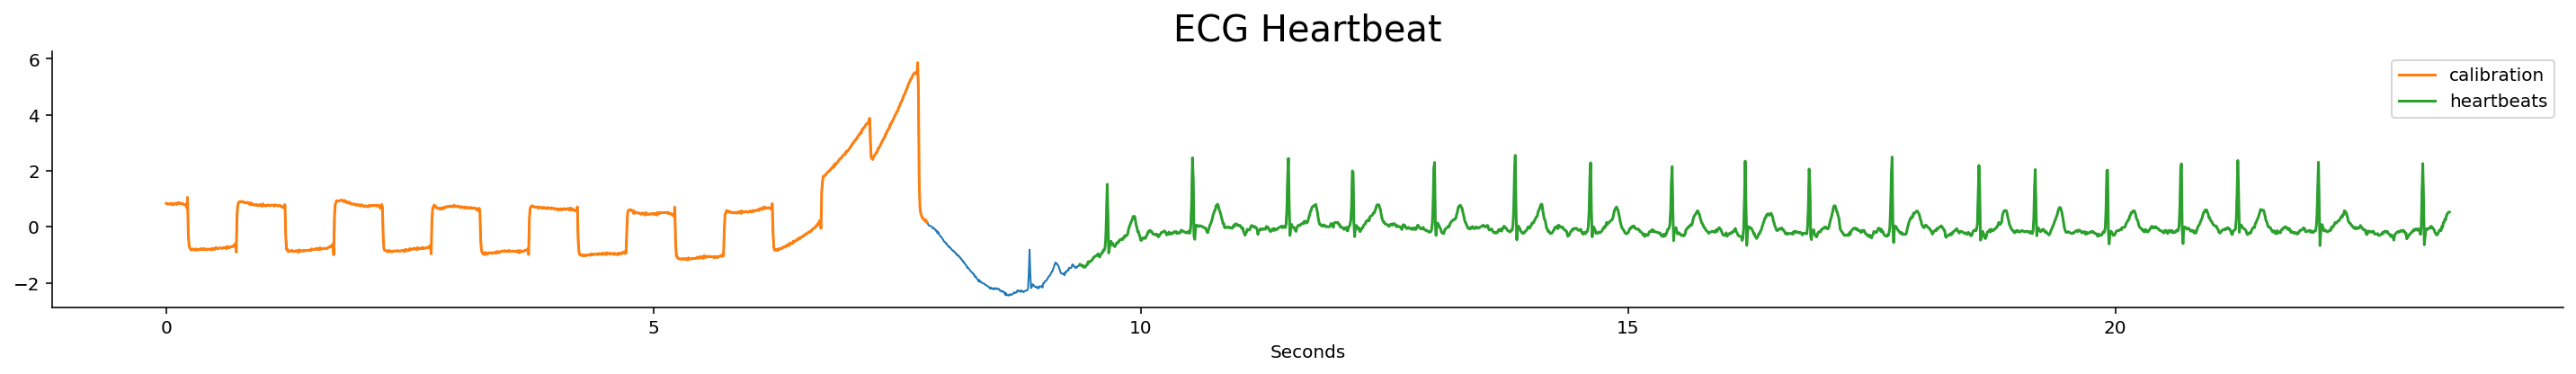

In [2]:
ds_name = "ECG Heartbeat"
file = 'ecg-heartbeat-av.csv'
series, df_gt = ml.read_dataset_with_index(file)
data = series.values
#series = ml.as_series(data, np.arange(0, 3000, 1) / 128, 'Seconds')
plot_dataset(file, series, ds_name=ds_name, ground_truth=df_gt)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
ks=20
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/ecg-heartbeat-av.csv


# k-Motiflets

## First, we learn the motif length l

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.64it/s]


Motif Length: 12 	 0.09375 	AU_PEF: 0.361 	#Elbows: 5


Compute ks: 100%|█████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.27it/s]


Motif Length: 25 	 0.1953125 	AU_PEF: 0.4 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 86.58it/s]


Motif Length: 37 	 0.2890625 	AU_PEF: 0.36 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


Motif Length: 50 	 0.390625 	AU_PEF: 0.279 	#Elbows: 5


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


Motif Length: 62 	 0.484375 	AU_PEF: 0.267 	#Elbows: 4


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 62.51it/s]


Motif Length: 75 	 0.5859375 	AU_PEF: 0.375 	#Elbows: 4


Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.70it/s]


Motif Length: 87 	 0.6796875 	AU_PEF: 0.462 	#Elbows: 4


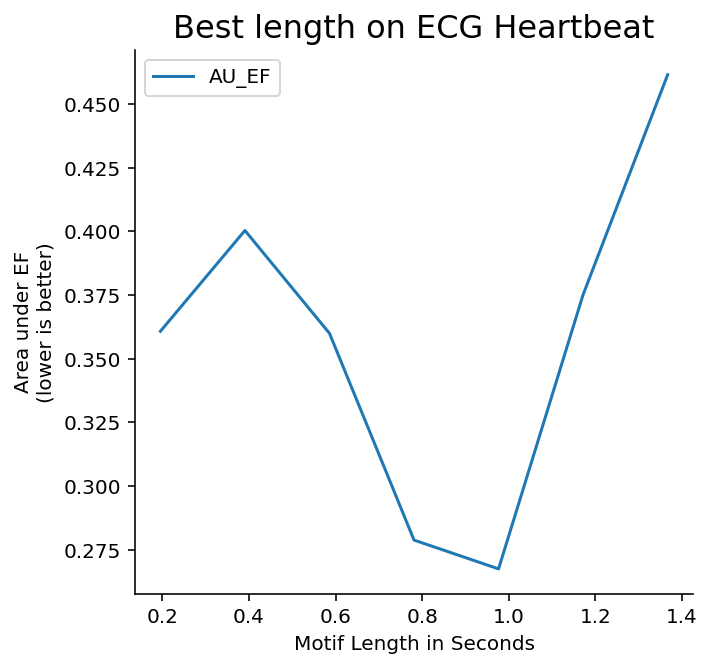

Found motif length 125


In [4]:
length_range = np.arange(25,200,25) 
motif_length = plot_motif_length_selection(
    ks, series, file, 
    motif_length_range=length_range, ds_name=ds_name)

print ("Found motif length", motif_length)

## Next, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:01<00:00, 14.11it/s]


Chosen window-size: 125
Identified Elbow Points [ 6  9 16]
Filtered Elbow Points [6, 16]


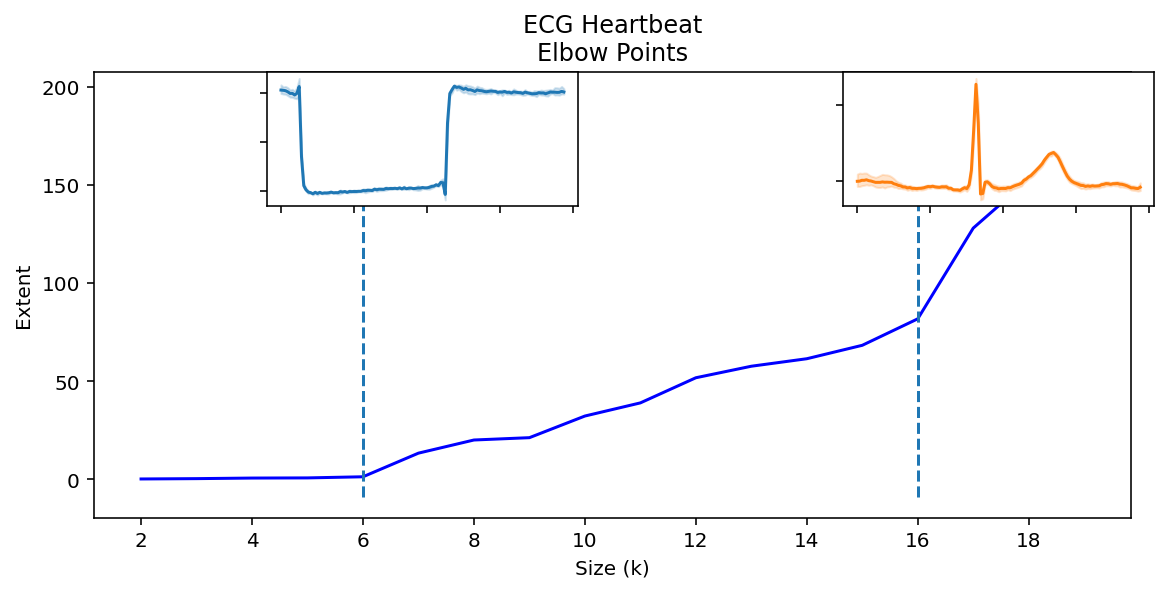

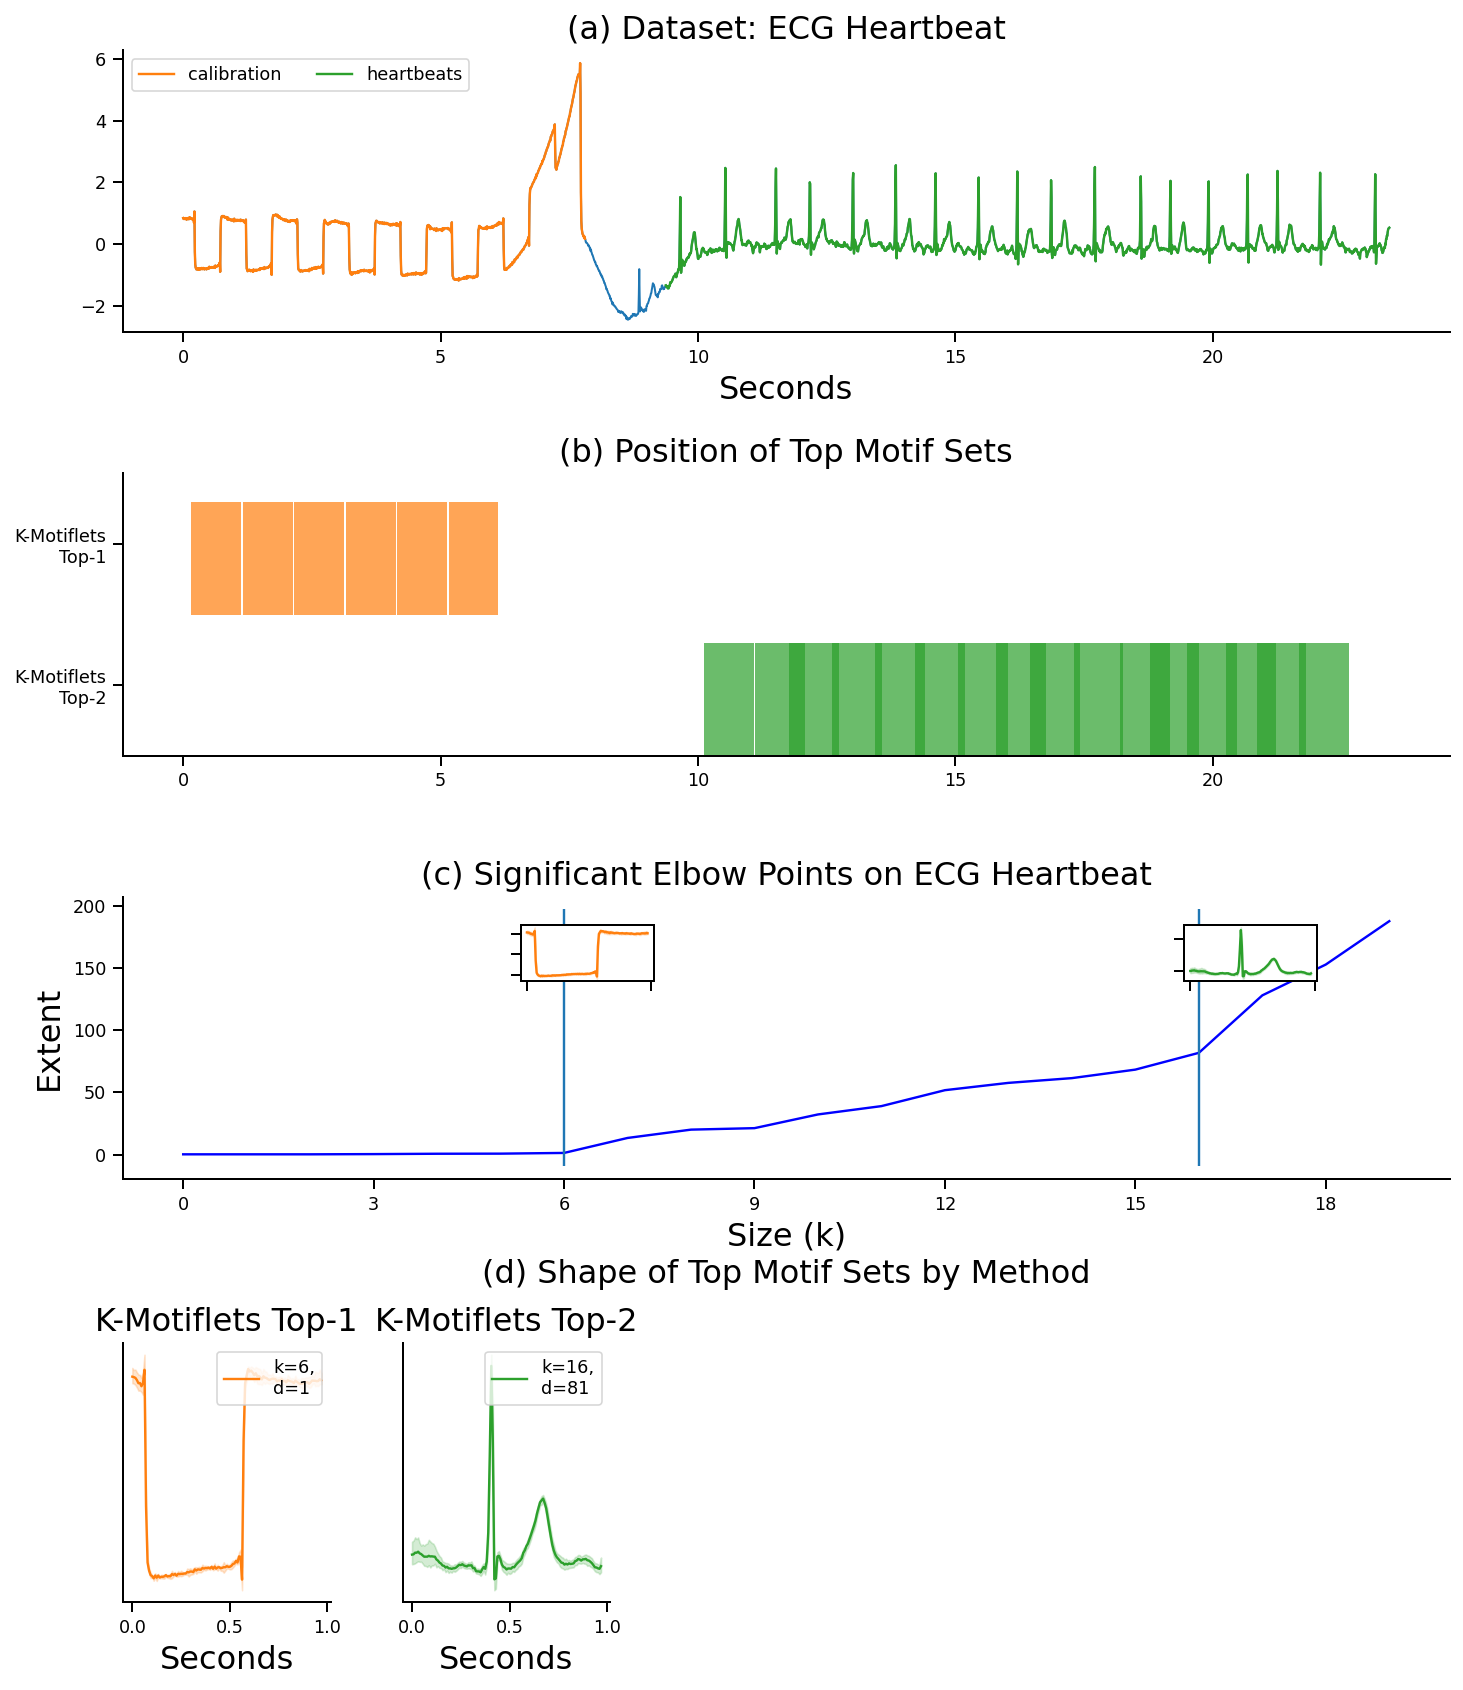

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets", ground_truth=df_gt)

In [6]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 55.67435836791992 0.8364326357841492
Extent d of TOP-1 Motif 81.79418182373047


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 11% on both parameters to reflect human trial-and-error.

In [7]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.11

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [ 0.83643264 55.67435837]
Best Radii	 [ 0.83643264 55.67435837]
Best Lengths	 125
Radii with human error	 [ 0.74442505 49.55017895]
Length with human error	 138


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [8]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

r: 0.4422960877418518 d: 0.9373919367790222
r: 43.80473709106445 d: 101.3080825805664
Filtered Elbow Points [0, 1]


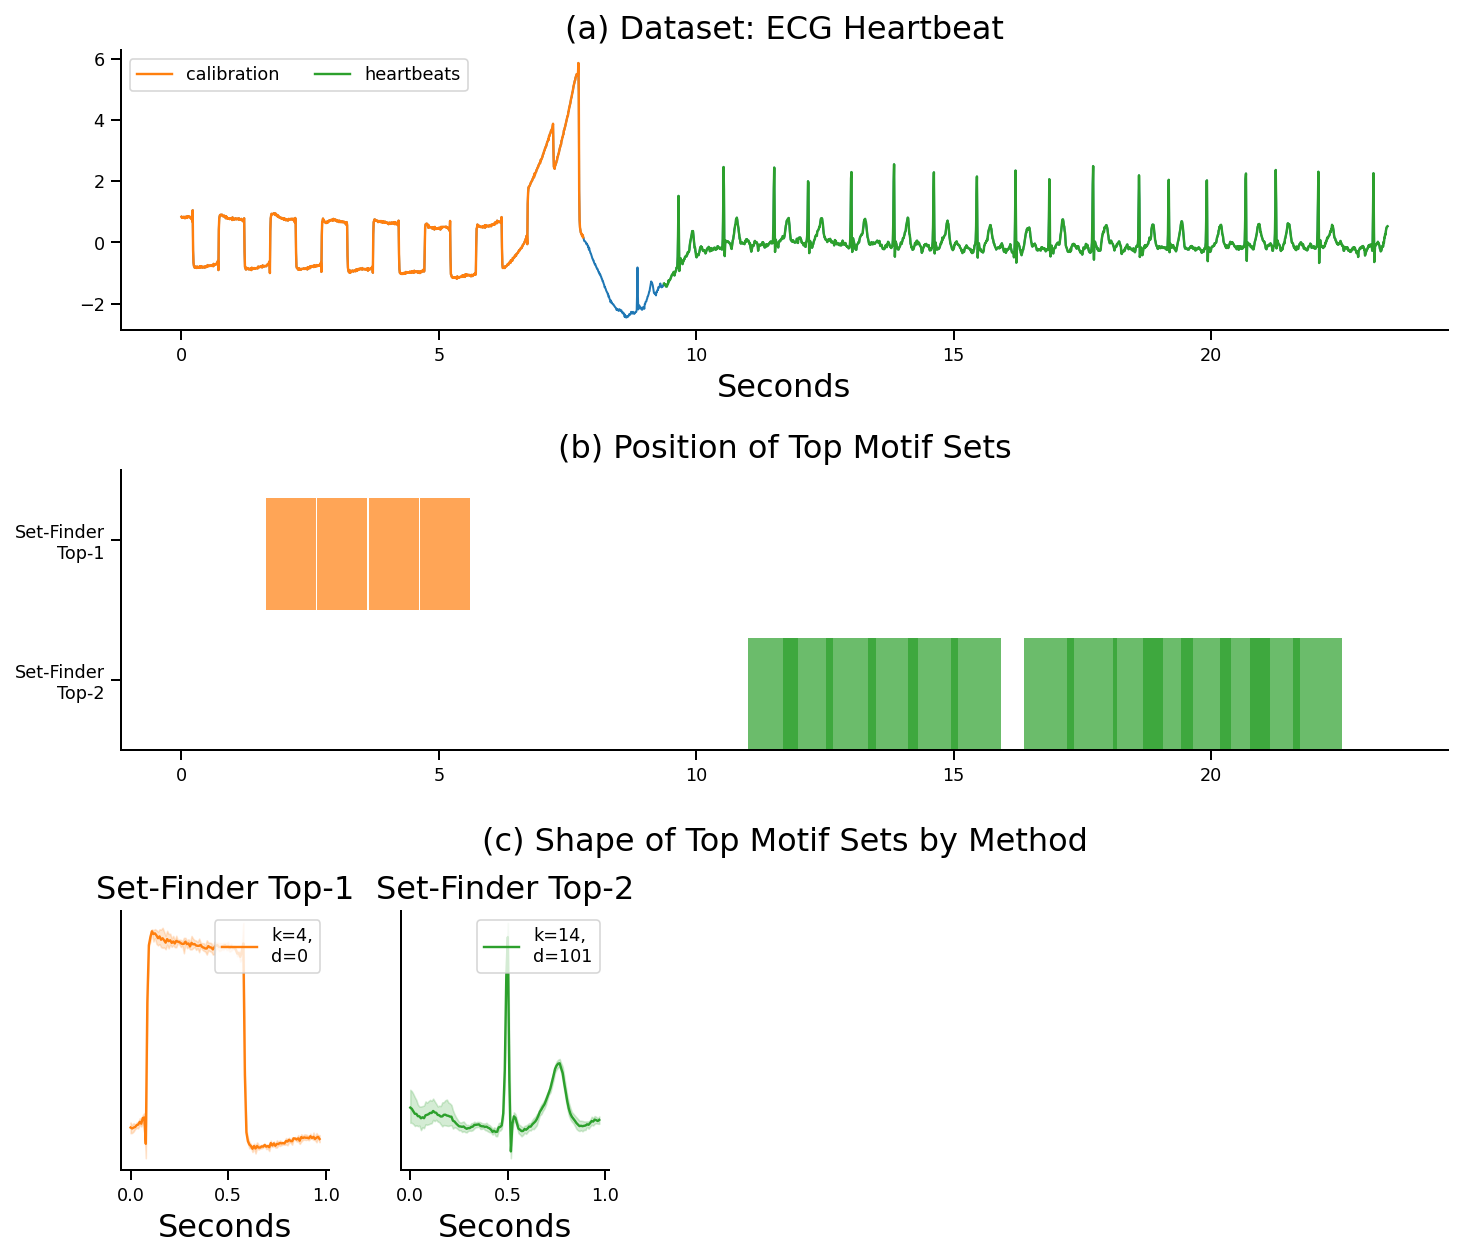

In [9]:
# run jave code first       
ms_set_finder = [
	[466, 210, 338, 594],
	[1708, 1410, 1495, 1602, 1807, 1914, 2095, 2203, 2317, 2391, 2486, 2583, 2657, 2763],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length,
                            prefix="Set-Finder", ground_truth=df_gt)
    
df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [10]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

r: 0.5316709876060486 d: 0.9164004325866699
r: 66.99336242675781 d: 77.43055725097656
Filtered Elbow Points [0, 1]


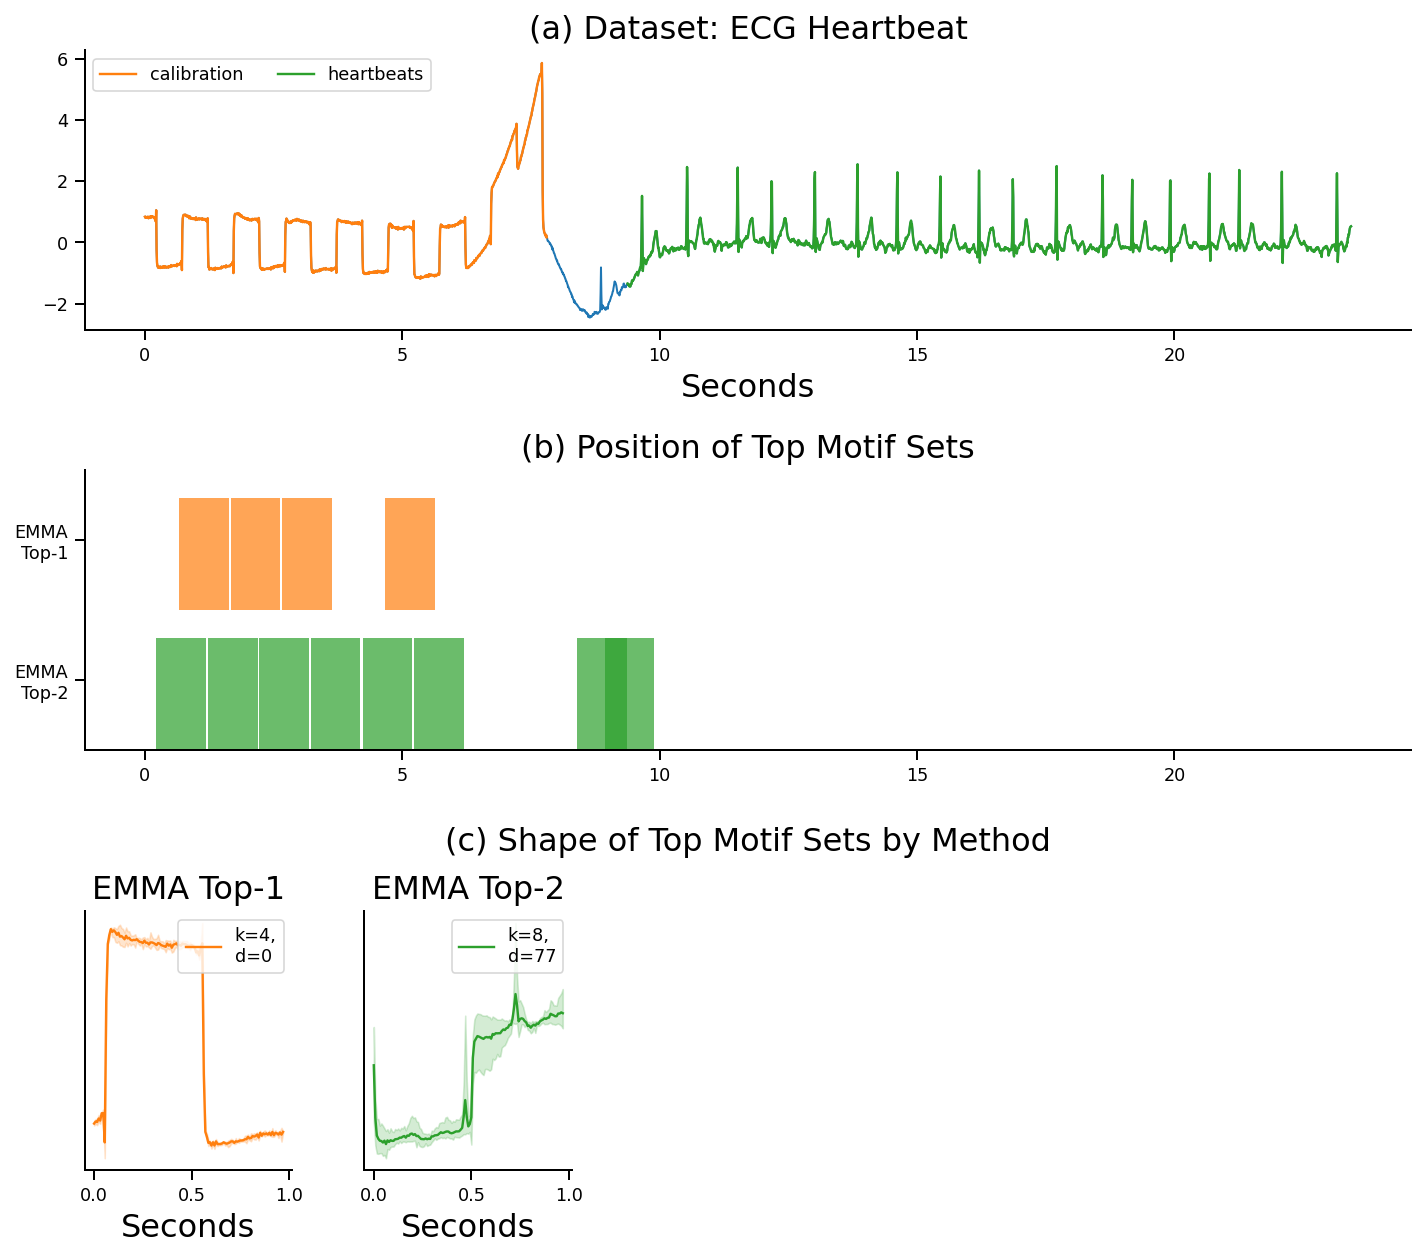

In [11]:
# run jave code first       
ms_emma = [
	[85, 213, 341, 597],
	[28, 156, 284, 412, 541, 669, 1074, 1143],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA", ground_truth=df_gt)

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 0.22491593658924103 d: 0.22491593658924103
r: 0.5094770193099976 d: 1.1327780485153198
r: 39.92774963378906 d: 46.17863082885742
r: 39.063751220703125 d: 90.51021575927734
Filtered Elbow Points [1, 2]


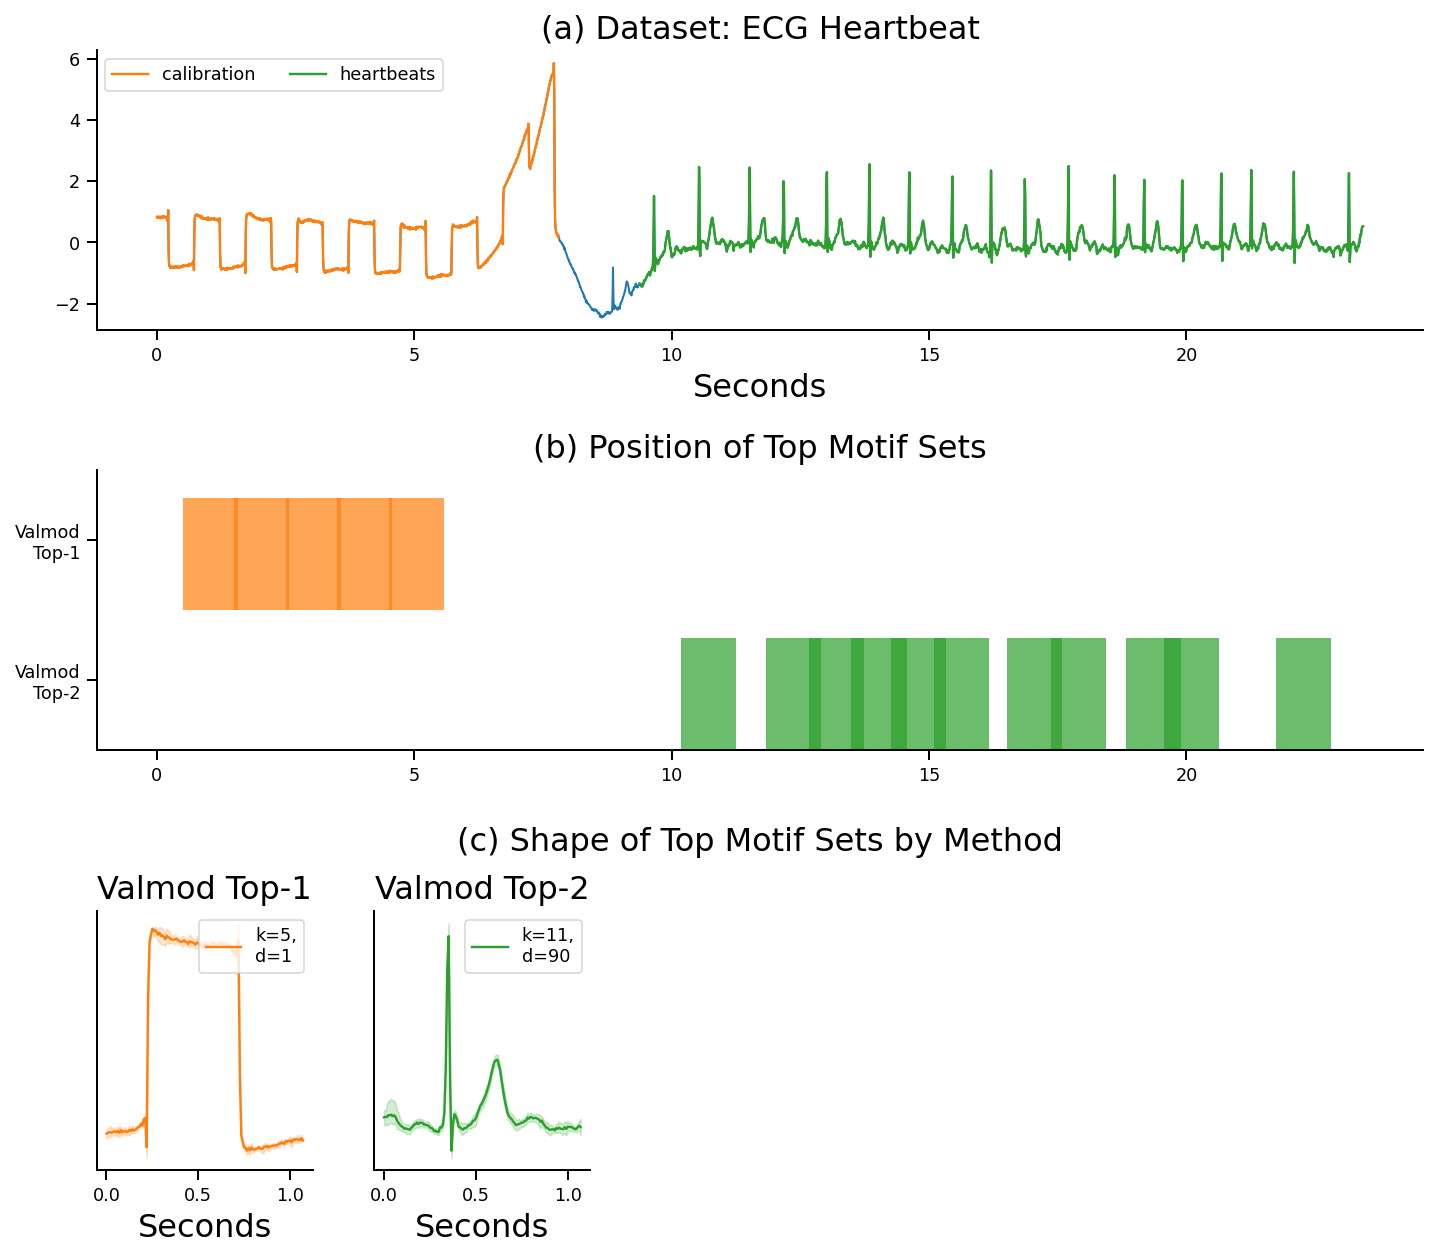

In [12]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod", ground_truth=df_gt)

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [13]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

r: 0.8672409057617188 d: 1.3706132173538208
r: 67.73328399658203 d: 112.1114730834961
Filtered Elbow Points [0, 1]


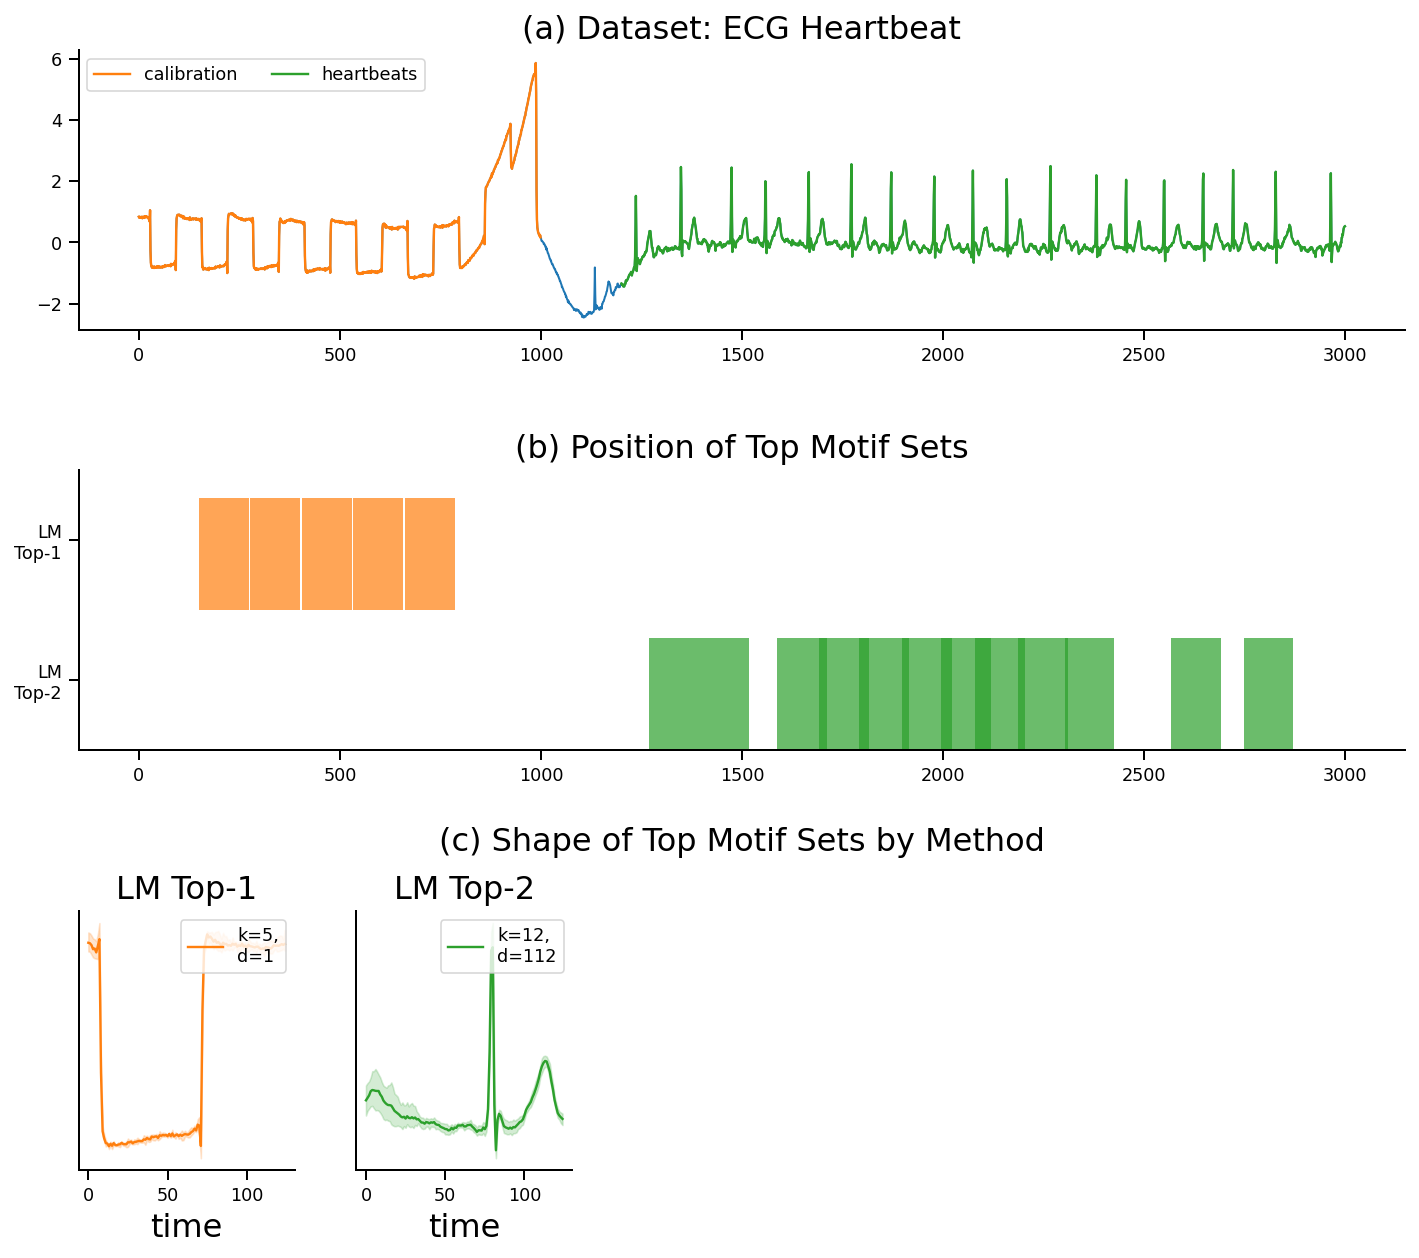

In [14]:
ms_learning_motifs = np.array([
	[149,277,405,533,661,],
	[1269,1394,1586,1692,1791,1898,1995,2079,2187,2302,2567,2747,],
])
    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM", ground_truth=df_gt)

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [15]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[2329, 2497, 1422, 1613, 2106, 1926, 2594, 129..."
Set Finder Top-1,"[1708, 1410, 1495, 1602, 1807, 1914, 2095, 220..."
EMMA Top-1,"[28, 156, 284, 412, 541, 669, 1074, 1143]"
VALMOD Top-1,"[1304, 1514, 1621, 1727, 1826, 1933, 2113, 222..."
LM Top-1,"[1269, 1394, 1586, 1692, 1791, 1898, 1995, 207..."
Motiflets Top-2,"[20, 148, 404, 532, 276, 660]"
Set Finder Top-2,"[466, 210, 338, 594]"
EMMA Top-2,"[85, 213, 341, 597]"
VALMOD Top-2,"[64, 192, 320, 448, 576]"
LM Top-2,"[149, 277, 405, 533, 661]"


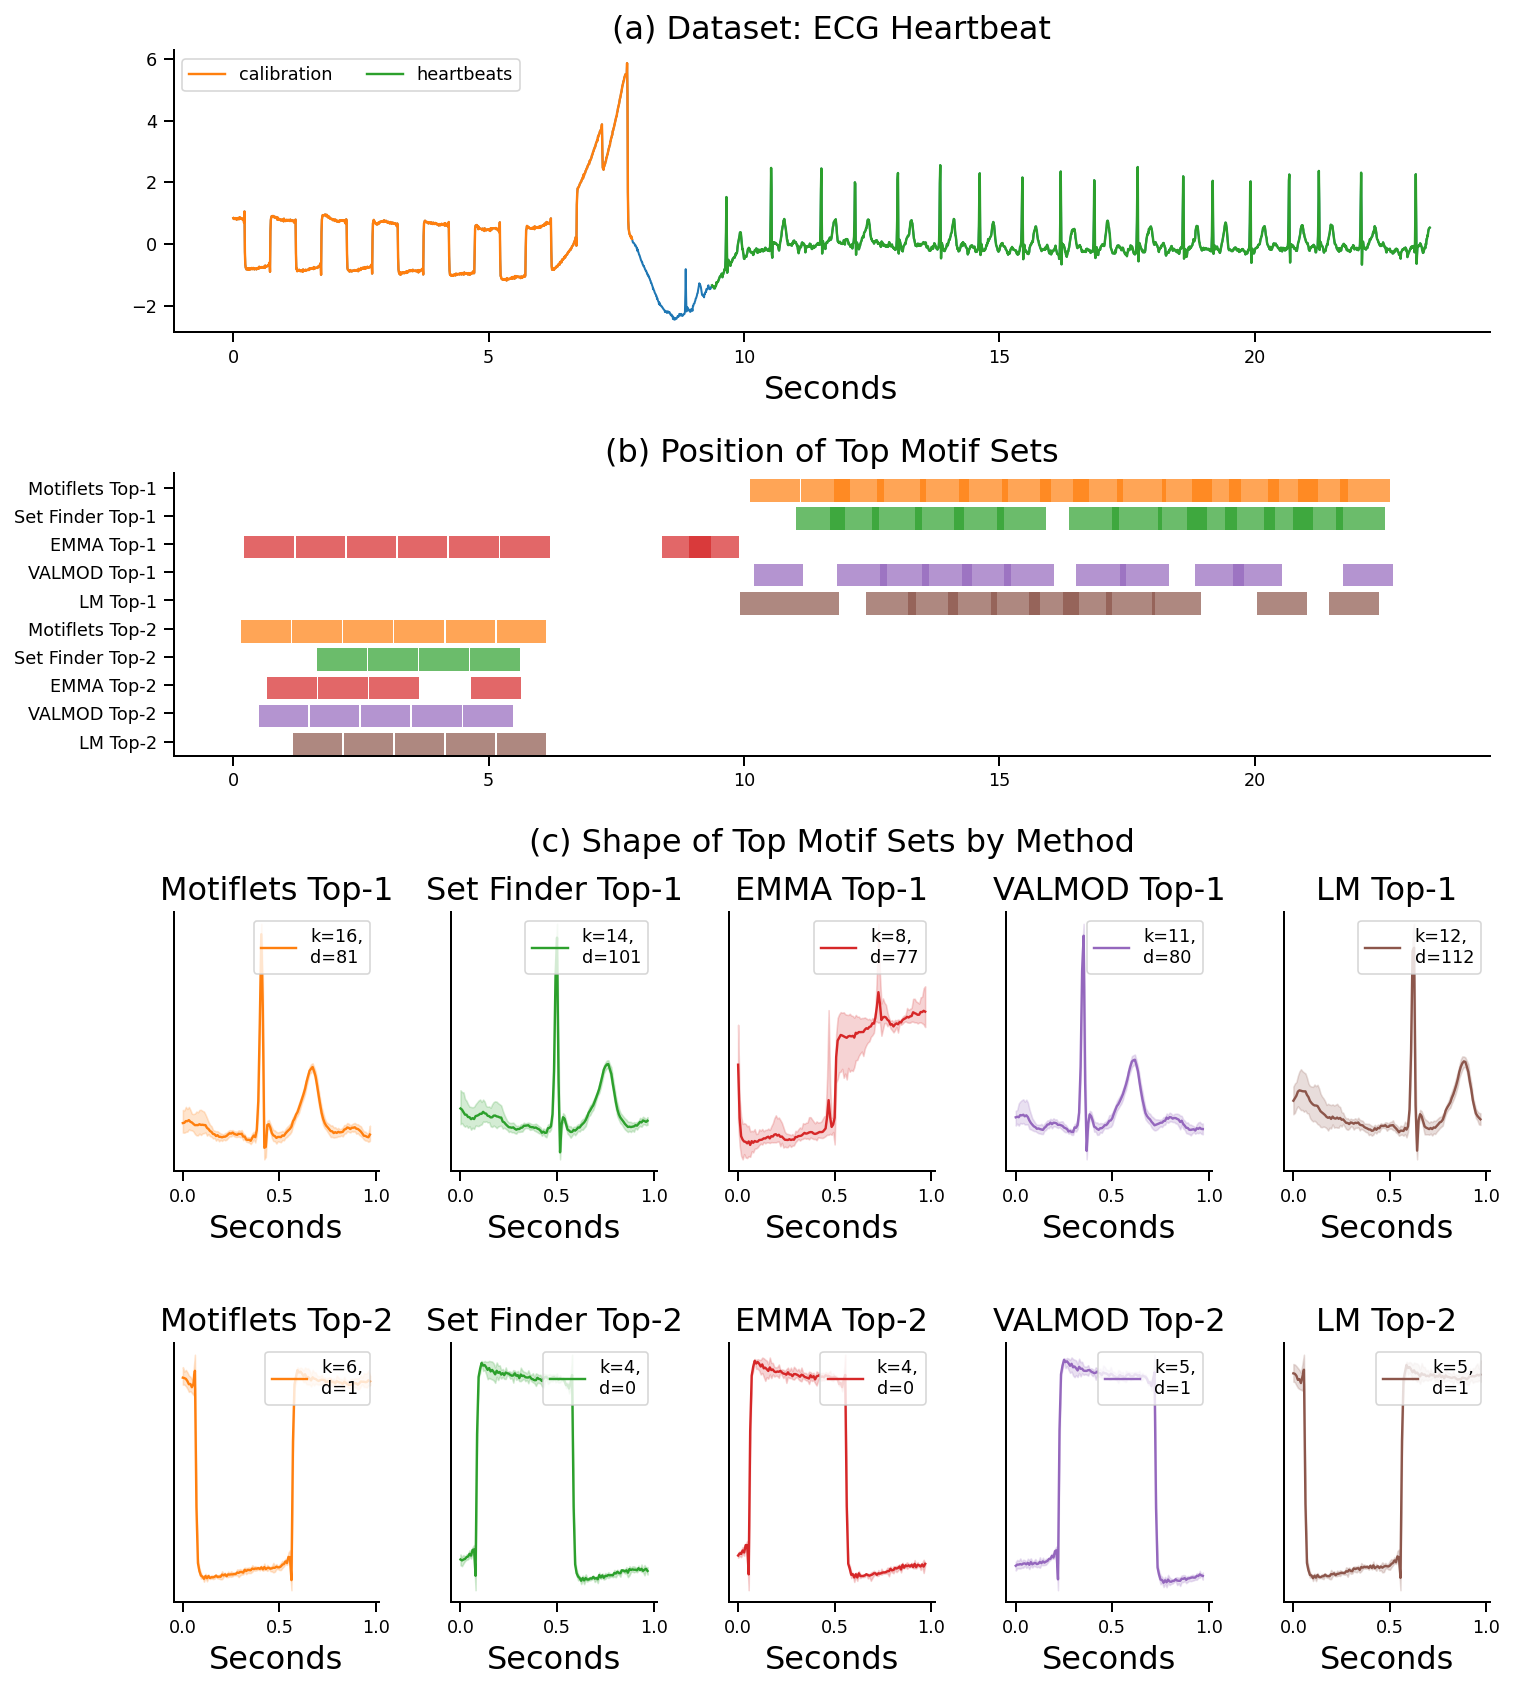

In [16]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values, ground_truth=df_gt)            